In [1]:
import h5py
from dataset import MPIIDataset
import numpy as np
from eval import pckh_score


import cv2
import matplotlib.pyplot as plt

/home/kt/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


original denotes mpii.pickle

In [2]:
mpii = np.load('./mpii.pickle')
fnames_original = [annot.image.name for annot in mpii.annolist]

- train/val/test = 22246/2958/11731 (from pose-hg-demo/annot)
- val/test = 2958/11731 (from -predictions-.h5 file)
- train+val/test = 18079/6908 (from mpii.pickle)
- train/val = 22245/6636 (from dataset.MPIIDataset)

In [3]:
annot = h5py.File('../../pose-hg-demo/annot/valid.h5')

data = dict()
for key, value in annot.items():
    data.update({key: value.value})

center <HDF5 dataset "center": shape (2958, 2), type "<f8">
imgname <HDF5 dataset "imgname": shape (2958,), type "|S13">
index <HDF5 dataset "index": shape (2958,), type "<f8">
normalize <HDF5 dataset "normalize": shape (2958,), type "<f8">
part <HDF5 dataset "part": shape (2958, 16, 2), type "<f8">
person <HDF5 dataset "person": shape (2958,), type "<f8">
scale <HDF5 dataset "scale": shape (2958,), type "<f8">
torsoangle <HDF5 dataset "torsoangle": shape (2958,), type "<f8">
visible <HDF5 dataset "visible": shape (2958, 16), type "<f8">


In [4]:
data.keys()

dict_keys(['center', 'imgname', 'index', 'normalize', 'part', 'person', 'scale', 'torsoangle', 'visible'])

In [5]:
fnames = map(lambda fname: fname.tobytes().decode('utf-8'), data['imgname'])
fnames = list(fnames)

# example

In [39]:
idx = 1
fnames[idx]

'052475643.jpg'

In [40]:
img = cv2.imread(f'/home/kt/data/MPII/images/{fnames[idx]}')

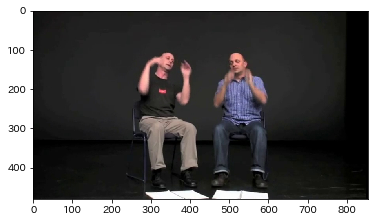

In [41]:
plt.imshow(img[:, :, ::-1])
plt.show()

In [42]:
idx_original = fnames_original.index(fnames[idx])
annot = mpii.annolist[idx_original]

In [43]:
img.shape

(480, 854, 3)

In [44]:
rect = annot.annorect[0]
rect.x1, rect.x2, rect.y1, rect.y2, annot.image.name, rect.objpos.x, rect.objpos.y, rect.scale*200

(316, 361, 105, 163, '052475643.jpg', 316, 220, 352.36708132287276)

In [45]:
center = (rect.objpos.x, rect.objpos.y)
scale = rect.scale * 200

In [46]:
center, rect.scale

((316, 220), 1.7618354066143638)

In [47]:
# image processing
shape = img.shape

xmin, xmax = center[0] - scale / 2, center[0] + scale / 2
ymin, ymax = center[1] - scale / 2, center[1] + scale / 2

# truncate
xmin = int(max(0, xmin))
ymin = int(max(0, ymin))
xmax = int(min(img.shape[1], xmax))
ymax = int(min(img.shape[0], ymax))

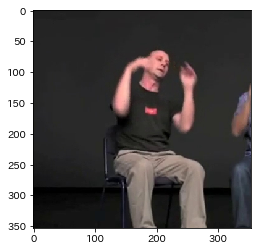

In [48]:
plt.imshow(img[ymin:ymax, xmin:xmax, ::-1])
plt.show()

**center, scale is different. point is the same one**

center by our method

In [50]:
0.5 * (xmin + xmax), 0.5 * (ymin + ymax), (ymax-ymin, xmax-xmin)

(315.5, 219.5, (353, 353))

In [51]:
center, rect.scale

((316, 220), 1.7618354066143638)

In [62]:
point_original = np.zeros((16, 2))
for point in annot.annorect[0].annopoints.point:
    point_original[point.id, 0] = point.x
    point_original[point.id, 1] = point.y

In [66]:
point_original.astype(np.int)

array([[317, 412],
       [318, 299],
       [290, 274],
       [353, 275],
       [403, 299],
       [394, 409],
       [322, 275],
       [327, 172],
       [329, 162],
       [347, 105],
       [296, 135],
       [281, 208],
       [296, 167],
       [358, 177],
       [387, 236],
       [392, 167]])

center, scale by their method

In [52]:
data['center'][idx], data['scale'][idx]

(array([316.       , 246.4275311]), 2.2022942582679548)

In [67]:
data['part'][idx].astype(np.int)

array([[317, 412],
       [318, 299],
       [290, 274],
       [353, 275],
       [403, 299],
       [394, 409],
       [322, 275],
       [327, 172],
       [329, 162],
       [347, 105],
       [296, 135],
       [281, 208],
       [296, 167],
       [358, 177],
       [387, 236],
       [392, 167]])

In [18]:
rect = annot.annorect[1]
rect.x1, rect.x2, rect.y1, rect.y2, annot.image.name, rect.objpos.x, rect.objpos.y

(495, 551, 105, 172, '052475643.jpg', 499, 232)

#  about predictions

### difference between annots and our dataset

In [2]:
preds = h5py.File('../../pose-hg-demo/preds/valid-example.h5')['preds'].value
preds.shape

(2958, 16, 2)

In [3]:
dataset = MPIIDataset(split='val')

2729


In [6]:
annot = h5py.File('../../pose-hg-demo/annot/valid.h5')

data = dict()
for key, value in annot.items():
    data.update({key: value.value})

In [7]:
data.keys()

dict_keys(['center', 'imgname', 'index', 'normalize', 'part', 'person', 'scale', 'torsoangle', 'visible'])

In [8]:
len(data['imgname'])

2958

In [9]:
fnames = map(lambda fname: fname.tobytes().decode('utf-8'), data['imgname'])
fnames = list(fnames)

In [13]:
annot_names = set(fnames)
dataset_names = set(dataset.paths)

In [22]:
# some of the validation dataset is duplicated
len(annot_names), len(fnames)

(2729, 2958)

In [23]:
len(annot_names.union(dataset_names)), len(annot_names), len(annot_names)

(2729, 2729, 2729)

## use their data to evaluate our evaluation code

In [3]:
preds = h5py.File('../../pose-hg-demo/preds/valid-example.h5')['preds'].value
preds.shape

(2958, 16, 2)

In [4]:
annot = h5py.File('../../pose-hg-demo/annot/valid.h5')

data = dict()
for key, value in annot.items():
    data.update({key: value.value})

In [6]:
data.keys()

dict_keys(['center', 'imgname', 'index', 'normalize', 'part', 'person', 'scale', 'torsoangle', 'visible'])

In [8]:
data['normalize']

array([117.96219733,  44.04588517,  78.48082568, ...,  42.9660331 ,
        87.        ,  23.75878785])

In [117]:
points = list()
indices = list()
scales = list()

for i in range(preds.shape[0]):
    keypoint = data['part'][i]
    scale = data['normalize'][i]
    
    point = np.zeros((16, 2), dtype=np.float)
    idx = np.zeros(16, dtype=np.bool)
    for i, (x, y) in enumerate(keypoint):
        if np.all(np.isclose((x, y), (0, 0))):
            # NOTE: should not be used
            point[i] = (-1, -1)
            idx[i] = False

        else:
            point[i] = (y, x)
            idx[i] = True

    points.append(point)
    indices.append(idx)
    scales.append(scale)

In [118]:
points = np.array(points)
indices = np.array(indices)
scales = np.array(scales)

In [110]:
corrects, counts = pckh_score(points, preds[:, :, ::-1], indices, scales)
corrects / counts

array([0.52366464, 0.65382015, 0.81271129, 0.80831643, 0.65584855,
       0.52467884, 0.85463151, 0.95571332, 0.95267072, 0.93002028,
       0.77214334, 0.83806626, 0.91446924, 0.92156863, 0.83772819,
       0.76538201])

In [111]:
# ignores 6, 7, 8
joints = {'head': [9, ], 'shoulder': [12, 13], 'elbow': [11, 14],
          'wrist': [10, 15], 'hip': [2, 3], 'knee': [1, 4], 'ankle': [0, 5]}

scores = dict()
for key, value in joints.items():
    score = corrects[value].sum() / counts[value].sum()
    scores.update({key: score})
print(scores)

{'head': 0.9300202839756593, 'shoulder': 0.9180189317106153, 'elbow': 0.8378972278566599, 'wrist': 0.768762677484787, 'hip': 0.8105138607167005, 'knee': 0.6548343475321163, 'ankle': 0.5241717376605814}


In [112]:
corrects, counts = pckh_score(points, preds[:, :, ::-1], avail, scales)
corrects / counts

array([0.72955083, 0.7778672 , 0.83212184, 0.82790859, 0.78248588,
       0.72817367, 0.87838777, 0.96418827, 0.96111869, 0.93826739,
       0.78005464, 0.84463373, 0.91881793, 0.92595109, 0.84515689,
       0.77827432])

In [121]:
corrects, counts = pckh_score(points, preds[:, :, ::-1], indices, scales)
corrects / counts

array([0.72955083, 0.7778672 , 0.83212184, 0.82790859, 0.78248588,
       0.72817367, 0.87838777, 0.96418827, 0.96111869, 0.93826739,
       0.78005464, 0.84463373, 0.91881793, 0.92595109, 0.84515689,
       0.77827432])

In [134]:
# ignores 6, 7
joints = {'head': [8, 9], 'shoulder': [12, 13], 'elbow': [11, 14],
          'wrist': [10, 15], 'hip': [2, 3], 'knee': [1, 4], 'ankle': [0, 5]}

scores = dict()
for key, value in joints.items():
    score = corrects[value].sum() / counts[value].sum()
    scores.update({key: score})
print(scores)

{'head': 0.9496930422919508, 'shoulder': 0.9223845108695652, 'elbow': 0.8448951764104312, 'wrist': 0.7791673805036834, 'hip': 0.8300155790202527, 'knee': 0.7801732822889381, 'ankle': 0.7288615965989608}


- Head	
    - valid-example	0.94985680676724	
    - valid-ours	0.96673822383587	
- Knee	
    - valid-example	0.78017653946277	
    - valid-ours	0.83094385522173	
- Ankle	
    - valid-example	0.72879828090489	
    - valid-ours	0.79069021418593	
- Shoulder	
    - valid-example	0.92237071846977	
    - valid-ours	0.94683122211511	
- Elbow	
    - valid-example	0.84484241857194	
    - valid-ours	0.8854224881895	
- Wrist	
    - valid-example	0.77916448294064	
    - valid-ours	0.83382255840645	

result of our evaluation and their evaluation
- **NOTE: validation split of theirs and ours are not the same one**
- **NOTE: evaluation code of theirs and ours are not the same one**

| Part    | ours |theirs|
| -----   | ---- | ---- |
| Head    | 0.93 | 0.95 |
| Knee    |**0.65**| 0.78 |
| Ankle   |**0.52**| 0.73 |
| Shoulder| 0.92 | 0.92 |
| Elbow   | 0.84 | 0.85 |
| Wrist   | 0.77 | 0.78 |

ignore zero point
**NOTE: in their metrics, set dist = -1 (considered as positive example?)**

| Part    | ours |theirs|
| -----   | ---- | ---- |
| Head    | 0.95 | 0.95 |
| Knee    | 0.78 | 0.78 |
| Ankle   | 0.73 | 0.73 |
| Shoulder| 0.92 | 0.92 |
| Elbow   | 0.84 | 0.84 |
| Wrist   | 0.78 | 0.78 |

### check of pred

In [28]:
from demo import MPIIVisualizer

In [74]:
idx = 10
fname = data['imgname'][idx].decode('utf-8')
print(fname)
img = cv2.imread(f'/home/kt/data/MPII/images/{fname}')

071324479.jpg


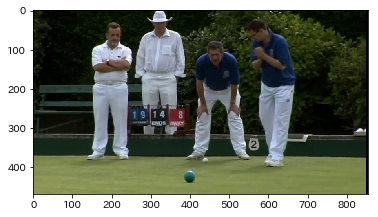

In [75]:
plt.imshow(img[:, :, ::-1])
plt.show()

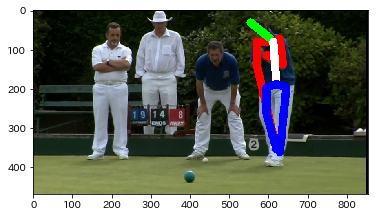

In [76]:
visulizer = MPIIVisualizer()

img_pred = visulizer.run(img, preds[idx, :, ::-1])

plt.imshow(img_pred[:, :, ::-1])
plt.show()

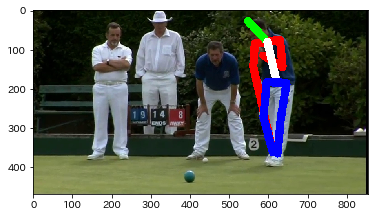

In [77]:
visulizer = MPIIVisualizer()

img_gt = visulizer.run(img, data['part'][idx, :, ::-1])

plt.imshow(img_gt[:, :, ::-1])
plt.show()

In [83]:
correct, size = pckh_score(points[10:11], preds[10:11, :, ::-1], indices[10:11], scales[10:11])
correct / size

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])